In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [2]:
errorlog = pd.read_csv("./data/errorlog0606_0612_edit.csv")

In [3]:
dates = list(range(6, 13))
hours = list(range(0, 24))
error_hours = []
error_times = []

for date in dates:
    for hour in hours:
        start = datetime.datetime(2020, 6, date, hour, 0, 0, 0)
        end = datetime.datetime(2020, 6, date, hour, 59, 59, 999999)
        
        e = errorlog[errorlog["EventTime"] <= end.timestamp()]    
        e = e[e["EventTime"] >= start.timestamp()]
        t = f"06{date:02d}-{hour:02d}~{(hour+1):02d}"
        error_hours.append(e["EventTime"].count())
        error_times.append(t)

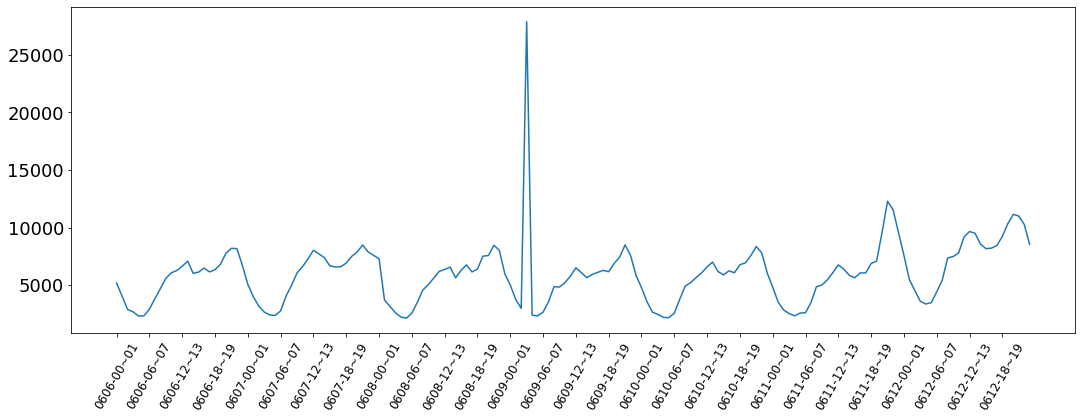

In [4]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [18, 6]
fig = plt.figure()
plt.plot(error_times, error_hours)
plt.xticks(error_times[::6], fontsize=12, rotation = 60)
plt.yticks(fontsize=18)
plt.show()

In [5]:
history = error_hours[0:24]
for _ in range(6):
    for e in error_hours[0:24]:
        history.append(e)
        
test = error_hours[24:]
predictions = []

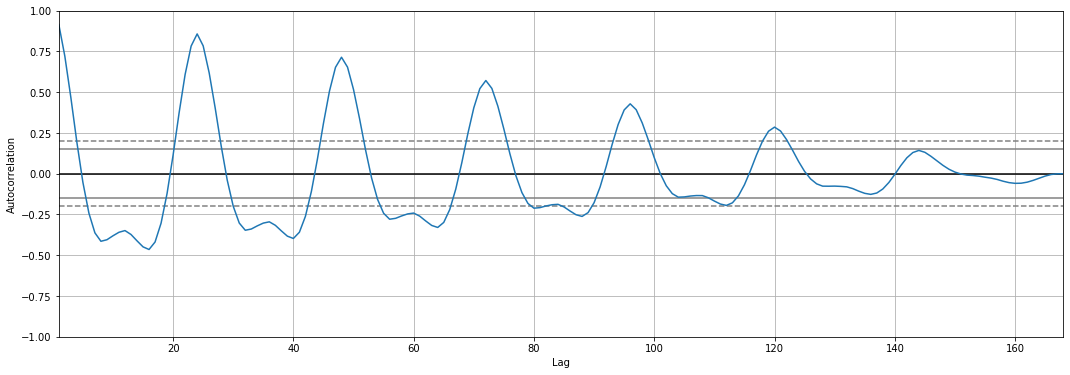

In [6]:
pd.plotting.autocorrelation_plot(history)
plt.rcParams['figure.figsize'] = [18, 6]
plt.show()

c:\users\kan\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


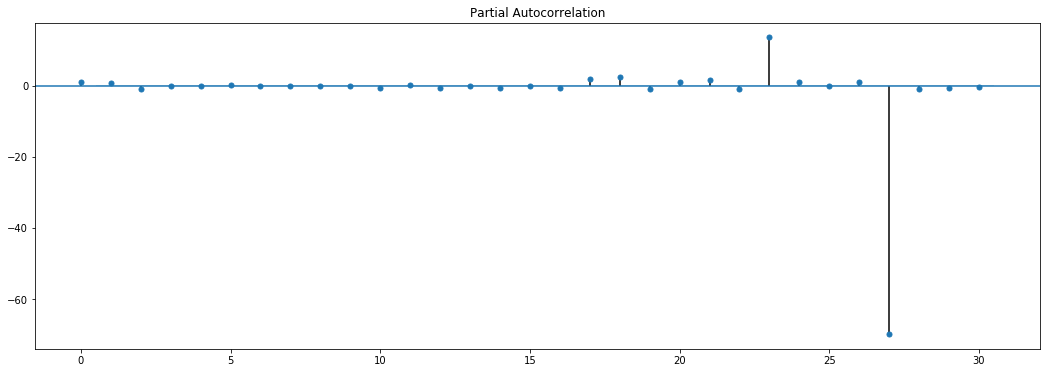

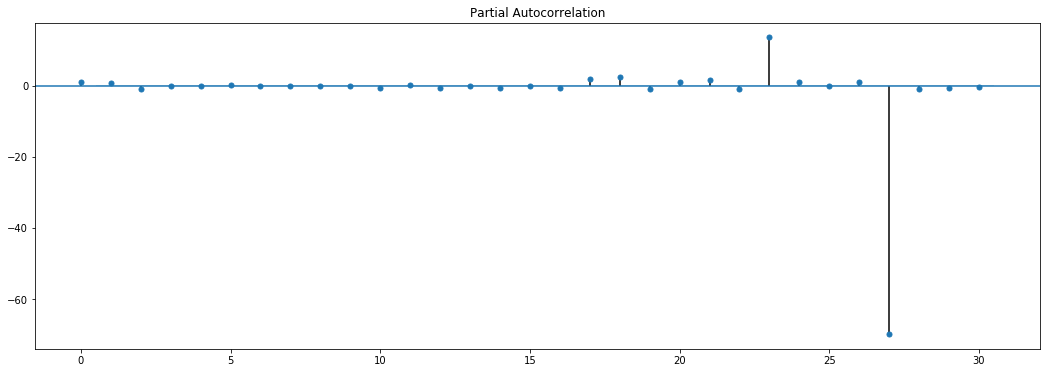

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(history, lags=30)

# Test

100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:10<00:00, 13.15it/s]


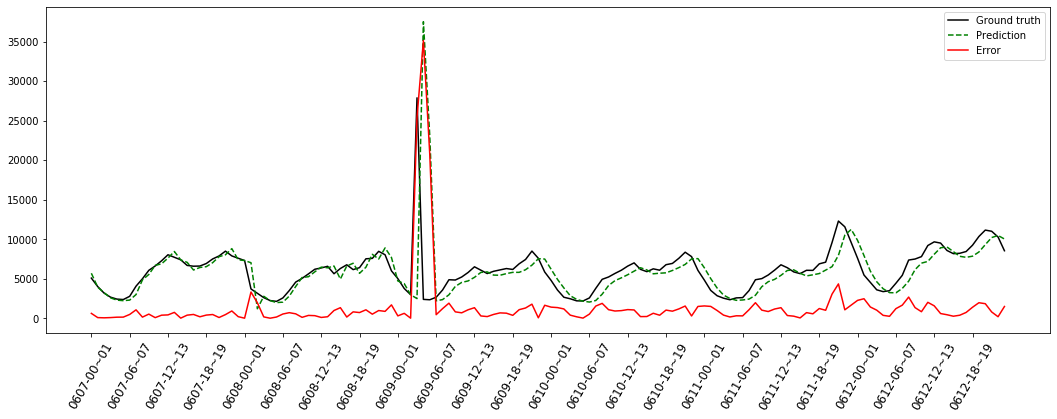

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

history = error_hours[0:24]
for _ in range(6):
    for e in error_hours[0:24]:
        history.append(e)
        
test = error_hours[24:]
predictions = []
test_mse = []

for t in tqdm(range(len(test))):
    model = SARIMAX(history, order=(2, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    del history[0]
    history.append(obs)
    test_mse.append(abs(yhat - obs))

fig = plt.figure()
plt.plot(error_times[24:], test, color='black', label='Ground truth')
plt.plot(error_times[24:], predictions, '--',color='green', label='Prediction')
plt.plot(error_times[24:], test_mse, color='red', label='Error')
plt.xticks(error_times[24:][::6], fontsize=12, rotation = 60)
plt.legend(loc='best')
plt.show()

# ARIMA

In [90]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

p_list = [0, 1, 2, 3, 6, 12, 18, 24]

for p in p_list:
    for q in range(1, 3):
        history = error_hours[0:24]
        for _ in range(6):
            for e in error_hours[0:24]:
                history.append(e)
        test = error_hours[24:]
        predictions = []
        test_mse = []
        
        print(f"-------------------p | {p}, q| {q}-----------")
        for t in tqdm(range(len(test))):
            model = SARIMAX(history, trend='c', order=(p, 1, q), enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t]
            test_mse.append(abs(yhat - obs))
            del history[0]
            if (abs(yhat - obs) < 5000):
                history.append(obs)
            else:
                history.append(yhat)
        
        plt.plot(error_times[24:], test, label='Ground truth')
        plt.plot(error_times[24:], predictions, color='red', label='Prediction')
        plt.plot(error_times[24:], test_mse, color='black', label='Error')
        plt.xticks(error_times[24:][::6], fontsize=12, rotation = 60)
        plt.legend(loc='best')
        plt.title(f'ARIMA (p,d,q)=({p},1,{q}) | Error={np.asarray(test_mse).mean():.02f}',fontsize=18)
        #plt.show()
        plt.savefig(f"./fig/w_drop_anomaly/ARIMA/ARIMA:p_{p}__q_{q}")
        plt.close()

  1%|▏         | 2/144 [00:00<00:07, 19.37it/s]

-------------------p | 0, q| 1-----------


  1%|▏         | 2/144 [00:00<00:09, 15.47it/s]

-------------------p | 0, q| 2-----------


  3%|▎         | 5/144 [00:00<00:03, 41.31it/s]

-------------------p | 1, q| 1-----------


  2%|▏         | 3/144 [00:00<00:05, 27.38it/s]

-------------------p | 1, q| 2-----------


  1%|          | 1/144 [00:00<00:16,  8.73it/s]

-------------------p | 2, q| 1-----------


  1%|          | 1/144 [00:00<00:24,  5.88it/s]

-------------------p | 2, q| 2-----------


  1%|          | 1/144 [00:00<00:28,  5.04it/s]

-------------------p | 3, q| 1-----------


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 3, q| 2-----------


  1%|          | 1/144 [00:00<00:27,  5.16it/s]

-------------------p | 6, q| 1-----------


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 6, q| 2-----------


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 12, q| 1-----------


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 12, q| 2-----------


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 18, q| 1-----------


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 18, q| 2-----------


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 24, q| 1-----------


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 24, q| 2-----------


100%|██████████| 144/144 [05:32<00:00,  2.31s/it]


# ARMA

In [91]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

p_list = [0, 1, 2, 3, 6, 12, 18, 24]

for p in p_list:
    for q in range(1, 3):
        history = error_hours[0:24]
        for _ in range(6):
            for e in error_hours[0:24]:
                history.append(e)
        test = error_hours[24:]
        predictions = []
        test_mse = []
        
        print(f"-------------------p | {p}, q| {q}-----------")
        for t in tqdm(range(len(test))):
            model = SARIMAX(history, trend='c', order=(p, 0, q), enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t]
            test_mse.append(abs(yhat - obs))
            del history[0]
            if (abs(yhat - obs) < 5000):
                history.append(obs)
            else:
                history.append(yhat)
        
        plt.plot(error_times[24:], test, label='Ground truth')
        plt.plot(error_times[24:], predictions, color='red', label='Prediction')
        plt.plot(error_times[24:], test_mse, color='black', label='Error')
        plt.xticks(error_times[24:][::6], fontsize=12, rotation = 60)
        plt.legend(loc='best')
        plt.title(f'ARMA (p,d,q)=({p},0,{q}) | Error={np.asarray(test_mse).mean():.02f}',fontsize=18)
        #plt.show()
        plt.savefig(f"./fig/w_drop_anomaly/ARMA/ARMA:p_{p}__q_{q}")
        plt.close()

  1%|▏         | 2/144 [00:00<00:10, 13.46it/s]

-------------------p | 0, q| 1-----------


  1%|          | 1/144 [00:00<00:14,  9.71it/s]

-------------------p | 0, q| 2-----------


  2%|▏         | 3/144 [00:00<00:04, 29.58it/s]

-------------------p | 1, q| 1-----------


  1%|▏         | 2/144 [00:00<00:07, 19.03it/s]

-------------------p | 1, q| 2-----------


  2%|▏         | 3/144 [00:00<00:06, 21.71it/s]

-------------------p | 2, q| 1-----------


  1%|          | 1/144 [00:00<00:16,  8.72it/s]

-------------------p | 2, q| 2-----------


  1%|          | 1/144 [00:00<00:18,  7.71it/s]

-------------------p | 3, q| 1-----------


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 3, q| 2-----------


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 6, q| 1-----------


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 6, q| 2-----------


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 12, q| 1-----------


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 12, q| 2-----------


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 18, q| 1-----------


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 18, q| 2-----------


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 24, q| 1-----------


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 24, q| 2-----------


100%|██████████| 144/144 [05:11<00:00,  2.16s/it]


# AR

In [92]:

p_list = [0, 1, 2, 3, 6, 12, 18, 24]

for p in p_list:
    history = error_hours[0:24]
    for _ in range(6):
        for e in error_hours[0:24]:
            history.append(e)
    test = error_hours[24:]
    predictions = []
    test_mse = []

    print(f"-------------------p | {p}, q| {q}-----------")
    for t in tqdm(range(len(test))):
        model = SARIMAX(history, trend='c', order=(p, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        test_mse.append(abs(yhat - obs))
        del history[0]
        if (abs(yhat - obs) < 5000):
            history.append(obs)
        else:
            history.append(yhat)

    plt.plot(error_times[24:], test, label='Ground truth')
    plt.plot(error_times[24:], predictions, color='red', label='Prediction')
    plt.plot(error_times[24:], test_mse, color='black', label='Error')
    plt.xticks(error_times[24:][::6], fontsize=12, rotation = 60)
    plt.legend(loc='best')
    plt.title(f'AR (p)=({p}) | Error={np.asarray(test_mse).mean():.02f}',fontsize=18)
    #plt.show()
    plt.savefig(f"./fig/w_drop_anomaly/AR/AR:p_{p}")
    plt.close()

  8%|▊         | 11/144 [00:00<00:01, 105.43it/s]

-------------------p | 0, q| 2-----------


  3%|▎         | 4/144 [00:00<00:04, 33.54it/s]

-------------------p | 1, q| 2-----------


  2%|▏         | 3/144 [00:00<00:04, 29.28it/s]

-------------------p | 2, q| 2-----------


  2%|▏         | 3/144 [00:00<00:05, 25.44it/s]

-------------------p | 3, q| 2-----------


  1%|▏         | 2/144 [00:00<00:10, 13.99it/s]

-------------------p | 6, q| 2-----------


  1%|          | 1/144 [00:00<00:23,  6.11it/s]

-------------------p | 12, q| 2-----------


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 18, q| 2-----------


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 24, q| 2-----------


100%|██████████| 144/144 [01:28<00:00,  1.63it/s]


# MA

In [93]:
for q in range(1, 8):
    history = error_hours[0:24]
    for _ in range(6):
        for e in error_hours[0:24]:
            history.append(e)
    test = error_hours[24:]
    predictions = []
    test_mse = []

    print(f"-------------------p | {p}, q| {q}-----------")
    for t in tqdm(range(len(test))):
        model = SARIMAX(history, trend='c', order=(0, 0, q), enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        test_mse.append(abs(yhat - obs))
        del history[0]
        if (abs(yhat - obs) < 5000):
            history.append(obs)
        else:
            history.append(yhat)

    plt.plot(error_times[24:], test, label='Ground truth')
    plt.plot(error_times[24:], predictions, color='red', label='Prediction')
    plt.plot(error_times[24:], test_mse, color='black', label='Error')
    plt.xticks(error_times[24:][::6], fontsize=12, rotation = 60)
    plt.legend(loc='best')
    plt.title(f'MA (p)=({q}) | Error={np.asarray(test_mse).mean():.02f}',fontsize=18)
    #plt.show()
    plt.savefig(f"./fig/w_drop_anomaly/MA/MA:q_{q}")
    plt.close()

  1%|▏         | 2/144 [00:00<00:11, 12.62it/s]

-------------------p | 24, q| 1-----------


  1%|          | 1/144 [00:00<00:17,  8.36it/s]

-------------------p | 24, q| 2-----------


  1%|          | 1/144 [00:00<00:20,  7.13it/s]

-------------------p | 24, q| 3-----------


  1%|          | 1/144 [00:00<00:28,  5.04it/s]

-------------------p | 24, q| 4-----------


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 24, q| 5-----------


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 24, q| 6-----------


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 24, q| 7-----------


100%|██████████| 144/144 [00:34<00:00,  4.24it/s]


  0%|          | 0/144 [00:00<?, ?it/s]

-------------------p | 24, q| 7-----------


100%|██████████| 144/144 [05:17<00:00,  2.21s/it]


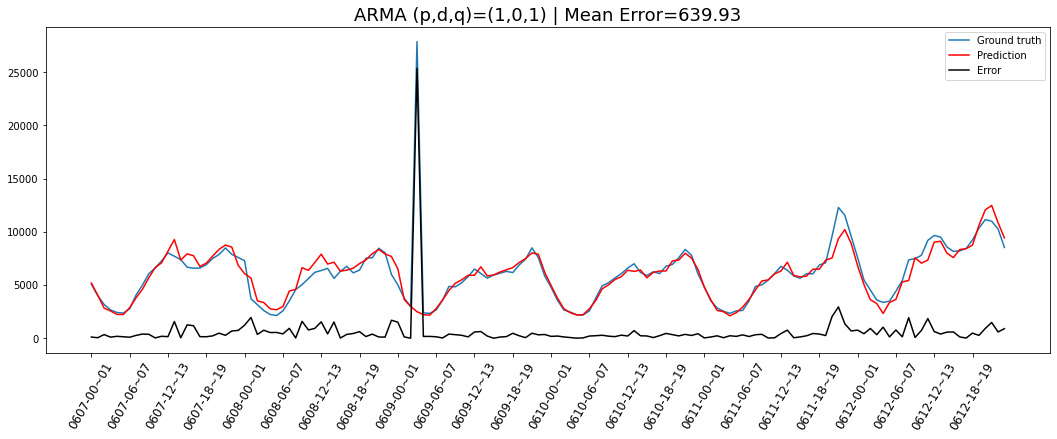

In [89]:
history = error_hours[0:24]
for _ in range(6):
    for e in error_hours[0:24]:
        history.append(e)
test = error_hours[24:]
predictions = []
test_mse = []

print(f"-------------------p | {p}, q| {q}-----------")
for t in tqdm(range(len(test))):
    model = SARIMAX(history, trend='c', order=(24, 0, 1), enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    test_mse.append(abs(yhat - obs))
    del history[0]
    if (abs(yhat - obs) < 5000):
        history.append(obs)
    else:
        history.append(yhat)

plt.plot(error_times[24:], test, label='Ground truth')
plt.plot(error_times[24:], predictions, color='red', label='Prediction')
plt.plot(error_times[24:], test_mse, color='black', label='Error')
plt.xticks(error_times[24:][::6], fontsize=12, rotation = 60)
plt.legend(loc='best')
plt.title(f'ARMA (p,d,q)=({1},0,{1}) | Mean Error={np.asarray(test_mse).mean():.02f}',fontsize=18)
plt.show()
#plt.savefig(f"./fig/ARMA/ARMA:p_{p}__q_{q}")
plt.close()